[How to use a stateful LSTM model, stateful vs stateless LSTM performance comparison](https://keras.io/examples/lstm_stateful/)

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

from matplotlib import pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
input_len = 1000
tsteps = 2
lahead = 1
batch_size = 1
epochs = 10

In [4]:
def gen_uniform_amp(amp=1, xn=10000):
    return pd.DataFrame(np.random.uniform(-amp, amp, xn))

In [5]:
to_drop = max(tsteps-1, lahead-1)
data_input = gen_uniform_amp(amp=0.1, xn=input_len + to_drop)
expected_output = data_input.rolling(window=tsteps, center=False).mean()

if lahead > 1:
    data_input = pd.DataFrame(
        np.repeat(data_input.values, repeats=lahead, axis=1)
    )
    for i,c in enumerate(data_inputs.columns):
        data_input[c] = data_input[c].shift(i)

expected_output = expected_output[to_drop:]
data_input = data_input[to_drop:]

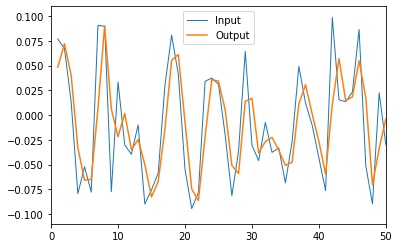

In [6]:
plt.plot(data_input[0], lw=1, label='Input')
plt.plot(expected_output[0], label='Output')
plt.xlim([0,50])
plt.legend()
plt.show()

In [19]:
def split_data(x, y, ratio=0.8):
    to_train = int(input_len * ratio)
    to_train -= to_train % batch_size
    x_train = x[:to_train]
    y_train = y[:to_train]
    x_test = x[to_train:]
    y_test = y[to_train:]
    
    to_drop = x_test.shape[0] % batch_size
    if to_drop > 0:
        # Deviate from the example here
        x_test = x_test[to_drop:]
        y_test = y_test[to_drop:]
        
    x_train = x_train.values.reshape((*x_train.shape, 1))
    x_test = x_test.values.reshape((*x_test.shape, 1))
    
    y_train = y_train.values
    y_test = y_test.values
        
    return (x_train, y_train), (x_test, y_test)

In [20]:
(x_train, y_train), (x_test, y_test) = split_data(data_input, expected_output)
print('x_train.shape: ', x_train.shape)
print('y_train.shape: ', y_train.shape)
print('x_test.shape: ', x_test.shape)
print('y_test.shape: ', y_test.shape)

x_train.shape:  (800, 1, 1)
y_train.shape:  (800, 1)
x_test.shape:  (200, 1, 1)
y_test.shape:  (200, 1)


In [21]:
def create_model(stateful):
    model = Sequential([
        LSTM(20, input_shape=(lahead,1), batch_size=batch_size,
             stateful=stateful),
        Dense(1),
    ])
    model.compile(optimizer='adam',
                  loss='mse')
    return model

In [22]:
model_stateful = create_model(stateful=True)

In [23]:
for i in range(epochs):
    print('Epoch', i+1, '/', epochs)
    model_stateful.fit(x_train, y_train,
                       batch_size=batch_size,
                       epochs=1, verbose=1,
                       validation_data=(x_test, y_test),
                       shuffle=False)
    model_stateful.reset_states()

Epoch 1 / 10
Train on 800 samples, validate on 200 samples
800/800 [==============================] - 14s 17ms/sample - loss: 6.2928e-04 - val_loss: 3.0585e-04
Epoch 2 / 10
Train on 800 samples, validate on 200 samples
800/800 [==============================] - 2s 3ms/sample - loss: 2.6621e-04 - val_loss: 2.9195e-04
Epoch 3 / 10
Train on 800 samples, validate on 200 samples
800/800 [==============================] - 2s 3ms/sample - loss: 2.5132e-04 - val_loss: 2.8783e-04
Epoch 4 / 10
Train on 800 samples, validate on 200 samples
800/800 [==============================] - 2s 3ms/sample - loss: 2.4224e-04 - val_loss: 2.8714e-04
Epoch 5 / 10
Train on 800 samples, validate on 200 samples
800/800 [==============================] - 2s 3ms/sample - loss: 2.3574e-04 - val_loss: 2.8602e-04
Epoch 6 / 10
Train on 800 samples, validate on 200 samples
800/800 [==============================] - 2s 3ms/sample - loss: 2.3062e-04 - val_loss: 2.8183e-04
Epoch 7 / 10
Train on 800 samples, validate on 200

In [24]:
predicted_stateful = model_stateful.predict(x_test, batch_size=batch_size)

In [25]:
model_stateless = create_model(stateful=False)
model_stateless.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs, verbose=1,
                    validation_data=(x_test, y_test),
                    shuffle=False)

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 4s 5ms/sample - loss: 0.0011 - val_loss: 9.2922e-04
Epoch 2/10
800/800 [==============================] - 2s 3ms/sample - loss: 8.8890e-04 - val_loss: 9.2539e-04
Epoch 3/10
800/800 [==============================] - 2s 3ms/sample - loss: 8.8527e-04 - val_loss: 9.2405e-04
Epoch 4/10
800/800 [==============================] - 2s 3ms/sample - loss: 8.8298e-04 - val_loss: 9.2318e-04
Epoch 5/10
800/800 [==============================] - 2s 3ms/sample - loss: 8.8135e-04 - val_loss: 9.2257e-04
Epoch 6/10
800/800 [==============================] - 2s 3ms/sample - loss: 8.8013e-04 - val_loss: 9.2213e-04
Epoch 7/10
800/800 [==============================] - 2s 3ms/sample - loss: 8.7916e-04 - val_loss: 9.2177e-04
Epoch 8/10
800/800 [==============================] - 2s 3ms/sample - loss: 8.7832e-04 - val_loss: 9.2145e-04
Epoch 9/10
800/800 [==============================] - 2s 3ms/sample - loss: 8.

In [26]:
predicted_stateless = model_stateless.predict(x_test, batch_size=batch_size)

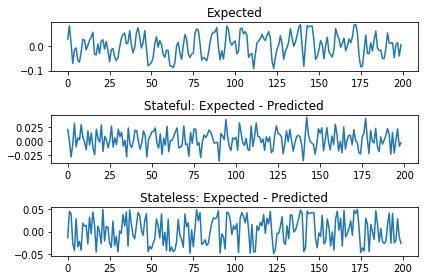

In [28]:
plt.subplot(3,1,1)
plt.plot(y_test)
plt.title('Expected')
plt.subplot(3,1,2)
plt.plot((y_test - predicted_stateful).flatten()[tsteps - 1:])
plt.title('Stateful: Expected - Predicted')
plt.subplot(3,1,3)
plt.plot((y_test - predicted_stateless).flatten())
plt.title('Stateless: Expected - Predicted')
plt.tight_layout()
plt.show()